## やりたいこと
`tf.dataset`の基礎学習

---

### データセットの生成
1から100までの整数を出力する それぞれの数はファイルに相当する

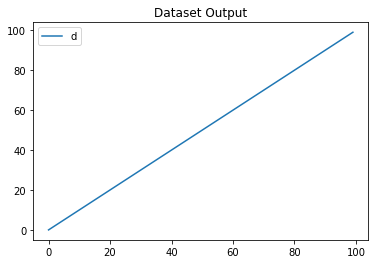

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def vis_dataset(dataset):
    x = []
    for item in dataset:
        x.append(item.numpy())  #入力はtf.tensorなので、numpyに変換する
    plt.plot(x)
    plt.legend("data sequence")
    plt.title("Dataset Output")
    plt.show()
        

Dataset = tf.data.Dataset.from_tensor_slices(np.arange(100))    #tf.rangeではなく、np.arangeを使う

vis_dataset(Dataset)

---

### リピートする

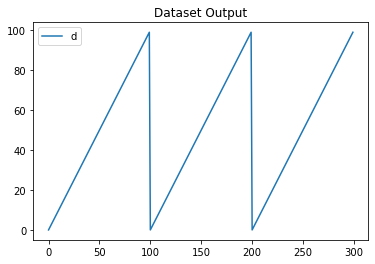

In [2]:
Dataset = tf.data.Dataset.from_tensor_slices(np.arange(100)).repeat(3)

vis_dataset(Dataset)

---

### 混ぜながらリピート出力する

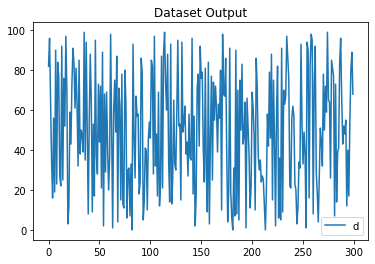

In [3]:
Dataset = tf.data.Dataset.from_tensor_slices(np.arange(100)).shuffle(100).repeat(3)

vis_dataset(Dataset)

訳が分からないので、元の出力とリピート出力を重ねる

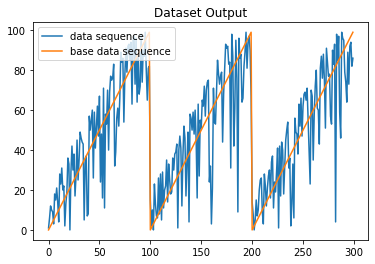

In [4]:
def vis_shuffle_dataset(dataset):
    x = []
    y = []
    base_dataset = tf.data.Dataset.from_tensor_slices(np.arange(100)).repeat(3)
    for item in dataset:
        x.append(item.numpy())  #入力はtf.tensorなので、numpyに変換する
    for item in base_dataset:
        y.append(item.numpy())
    plt.plot(x)
    plt.plot(y)
    plt.legend(["data sequence","base data sequence"])
    plt.title("Dataset Output")
    plt.show()

Dataset = tf.data.Dataset.from_tensor_slices(np.arange(100)).shuffle(20).repeat(3)  #判りやすくするためにshuffle幅を制限
vis_shuffle_dataset(Dataset)

---

### `map`で値を変質させながら出力させる
ガウシアンノイズを加える

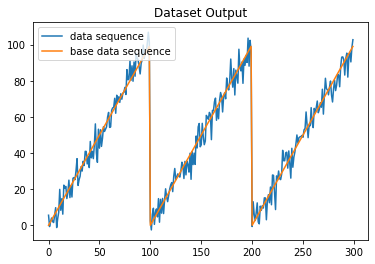

In [5]:
def add_gaaussian_noize(X):
    x = X + (np.random.randn(1,) * 5) #判りやすくするためにノイズ量を5倍する
    return x

@tf.function
def tf_add_gaaussian_noize(X):
    x = tf.py_function(add_gaaussian_noize,[X],[tf.float32])
    return x[0]

Dataset = tf.data.Dataset.from_tensor_slices(np.arange(100).astype(np.float32)).map(tf_add_gaaussian_noize).repeat(3)   #結果をわかりやすくするためシャッフルを外す

vis_shuffle_dataset(Dataset)

～出力値にガウシアンノイズ(の5倍)がランダムに乗っているのがわかる  
シャッフルをかけると、グラフ上は意味が分からなくなるが、出力順がシャッフルされつつ出力値がランダマイズされる  
(ノイズ付与前はデータレンジが0～100だったのが、ノイズ付与後は0以下/100以上が出力されている)

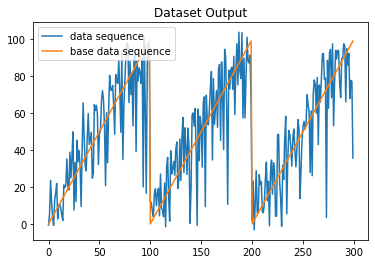

In [7]:
Dataset = tf.data.Dataset.from_tensor_slices(np.arange(100).astype(np.float32)).map(tf_add_gaaussian_noize).shuffle(20).repeat(3)

vis_shuffle_dataset(Dataset)

## わかったこと
### この結果の意味するところ
- `numpy.nparray`を`tf.data.Dataset.from_tensor_slices`に通すことで、`Dataset`を生成できる
- `Dataset`はジェネレータなので、逐次的に値を吐き出してくれる
- 今回はやっていないが、`tf.data.Dataset.batch()`を利用すれば、バッチごとの出力が可能
- 'tf.data.Dataset.map()'を利用することで、`Dataset`の個々の要素に変換をかけられる。乱数系関数が有効  
(`Dataset`要素全体に変換をかけるときは`tf.data.Dataset.apply()`を使えばよい)

### 文法的な気づき
- 'tf.data.Dataset.map()'の変換は、Tensorflowが実行できる関数(TF関数)である必要がある  
`@Ttf.function`デコレータはTensorflowグラフへのコンパイル、`tf_py.function`はPython関数をtensorflow関数にラップする働きを持つ  
→`tf.py_function`の中通常の関数を書き、そこに`@tf.function`デコレータをつけることでコンパイルするイメージ  
※`@tf.function`だけだと、中身はTF関数で書かなければならないことに注意

## 次にやること
- MNISTを使って2次元データのAugmentationを組んでみる これができればスペクトログラムのバッチ出力化が可能  
…相変わらず増穂環境で動かないのがネックだが…
- `TFRecord`によるシリアライズ。ただしこれは`tf.data.Dataset`の総量がメモリサイズを超えるときの措置で、収まるのなら必要ない  
…実際読み込むのは1ファイル5秒程度の音声ファイルなので、そこまでメモリは圧迫しないと思う